In [1]:
from dataget import data
import tfinterface as ti
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz
from dicto import dicto

sess = tf.InteractiveSession()

## Dataget
To download and import the data we will use dataget here but you can import the mnist however you want, there are various ways to import the mnist like using keras sample datasets. The first time you run this code `dataget` will download, extract, and transform the `MNIST` to jpg images; any subsequent calls use the cached data. 

In [2]:
dataset = data("mnist").get()

dataset.training_set.df.columns

Index([u'class_id', u'filename'], dtype='object')

The `.get` method returns a `Dataset` object which has a `training_set` and `test_set` `SubSet` properties, these subsets include varios methods for loading the images, getting random batches, etc. However, each subset by default include a `.df` property which the columns filename (full path to the actual image) and class_id (number show in the image), although you sometimes wan't a generator of (image, label) batches, we will make TensorFlow do the IO for us so just having the filenames is perfect.

## Estimator API, input_fn & Dataset API
 

In [3]:
def input_fn(df, img_shape = [28, 28], embeddings_shape = [1, 1, 100], epochs = 10, batch_size = 64, buffer_size = 500):

    def parse(filename, class_id):

        img = tf.read_file(filename)
        img = tf.image.decode_jpeg(img, channels = 1)
        img = tf.image.resize_images(img, img_shape)

        return img, class_id


    # ds
    ds = tf.data.Dataset.from_tensor_slices((df.filename.as_matrix(), df.class_id.as_matrix()))
    ds = ds.map(parse)
    ds = ds.shuffle(buffer_size = buffer_size)
    ds = ds.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    ds = ds.repeat(epochs)

    # get iterator
    iterator = ds.make_one_shot_iterator()
    image, class_id = iterator.get_next()

    return dict(image = image, class_id = class_id), None

{'class_id': <tf.Tensor 'IteratorGetNext:1' shape=(20,) dtype=int64>, 'image': <tf.Tensor 'IteratorGetNext:0' shape=(20, 28, 28, 1) dtype=float32>}


/home/cristian/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


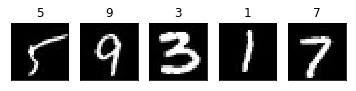

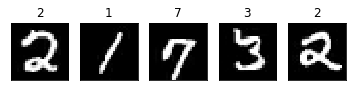

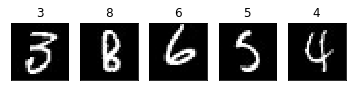

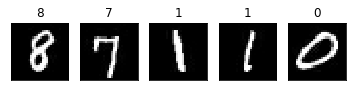

In [4]:
features, _ = input_fn(dataset.training_set.df, batch_size=20)

image = features["image"]
class_id = features["class_id"]

print(features)
    
images, class_ids = sess.run([image, class_id])

for tup in cz.partition(5, zip(images, class_ids)):

    fig, axes = plt.subplots(1, 5, subplot_kw=dict())

    for i, (img, class_id) in enumerate(tup):


        img = np.squeeze(img).astype(np.uint8)

        axes[i].imshow(img, cmap="gray")
        axes[i].title.set_text(class_id)
        axes[i].get_yaxis().set_visible(False)
        axes[i].get_xaxis().set_visible(False)

    fig.show()

plt.show()

In [5]:
class AllCNNN(snt.AbstractModule):
    
    def __init__(self, *args, **kwargs):
        kwargs["name"] = kwargs.get("name", "AllCNN")
        super(AllCNNN, self).__init__(*args, **kwargs)
    
    def _build(self, inputs):
        
        print("##########################")
        print("## AllCNN")
        print("##########################")
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        net = ti.layers.conv2d_batch_norm(net, 16, [4, 4], strides = 2, activation = tf.nn.relu, 
                                          padding = "same", batch_norm = dict(training = training)); print(net)
        
        
        net = ti.layers.conv2d_batch_norm(net, 32, [4, 4], strides = 2, activation = tf.nn.relu, 
                                          padding = "same", batch_norm = dict(training = training)); print(net)
        
        
        net = ti.layers.conv2d_batch_norm(net, 64, [3, 3], strides = 1, activation = tf.nn.relu, 
                                          padding = "valid", batch_norm = dict(training = training)); print(net)
        
        
        net = tf.layers.conv2d(net, 10, [3, 3], strides = 1, activation = tf.nn.relu,
                                          padding = "valid"); print(net)
        
        
        
        # global average pooling
        logits = net = tf.reduce_mean(net, axis = [1, 2]); print(net)
        
        # predictions
        predictions = net = tf.nn.softmax(logits); print(net)
    
        print("")
        
        return logits, predictions

In [6]:
inputs = dict(
    image = tf.layers.Input(shape=(28, 28, 1)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

all_cnn = AllCNNN()
logits, predictions = all_cnn(inputs)

##########################
## AllCNN
##########################
Tensor("input_layer_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_1/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_2/Relu:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d/Relu:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)



In [7]:
def model_fn(features, labels, mode, params):
    
    inputs = features
    inputs["mode"] = mode
    
    # create networks
    all_cnn = AllCNNN()
    
    # predictions
    logits, predictions = all_cnn(inputs)
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = dict(
                classes = predictions,
                image = inputs["image"],
            )
        )
    
    
    # loss
    labels = features["class_id"]
    onehot_labels = tf.one_hot(labels, 10)
    
    loss = tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = onehot_labels)
    loss = tf.reduce_mean(loss)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = predictions,
            loss = loss,
            eval_metric_ops = dict(
                accuracy = tf.metrics.accuracy(
                    labels = labels,
                    predictions = tf.argmax(predictions, axis = 1)
                )
            )
        )
    
    #update
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(loss, global_step = tf.train.get_global_step())
        
    
    accuracy = tf.contrib.metrics.accuracy(
        labels = labels,
        predictions = tf.argmax(predictions, axis = 1)
    )
        
    # metrics
    tf.summary.scalar("accuracy", accuracy)
    
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = update,
        training_hooks = [
            tf.train.LoggingTensorHook(
                dict(
                    loss = loss, 
                    accuracy = accuracy
                ),  
                every_n_iter = 50
            )
        ],
    )

In [8]:
params = dicto.load_("parameters.yml")

estimator = tf.estimator.Estimator(
    model_fn = model_fn,
    model_dir = params.model_dir,
    params = params,
    config = tf.estimator.RunConfig(save_checkpoints_steps = params.checkpoint_steps, save_summary_steps = params.summary_steps)
)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f91ec53cc10>, '_save_checkpoints_steps': 50, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models/all_cnn2', '_save_summary_steps': 50}


In [11]:
params = dicto.load_("parameters.yml")

estimator.train(
    input_fn = lambda: input_fn(
        dataset.training_set.df, 
        batch_size = params.batch_size, 
        epochs = params.epochs,
    )
)

##########################
## AllCNN
##########################
Tensor("IteratorGetNext:0", shape=(64, 28, 28, 1), dtype=float32, device=/device:CPU:0)
Tensor("AllCNN/Conv2dBatchNorm/Relu:0", shape=(64, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_1/Relu:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_2/Relu:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d/Relu:0", shape=(64, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(64, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(64, 10), dtype=float32)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from models/all_cnn2/model.ckpt-302
INFO:tensorflow:Saving checkpoints for 303 into models/all_cnn2/model.ckpt.
INFO:tensorflow:loss = 0.149795, step = 303
INFO:tensorflow:loss = 0.149795, accuracy = 0.96875
INFO:tensorflow:Saving checkpoints for 353 into models/all_cnn2/model.ckpt.
INFO:tensorflow:loss = 0.0390556, accuracy = 1.0 (1.275 sec)
INF

KeyboardInterrupt: 

In [10]:
params = dicto.load_("parameters.yml")

estimator.evaluate(
    input_fn = lambda: input_fn(
        dataset.test_set.df, 
        batch_size = params.batch_size, 
        epochs = 1
    )
)

##########################
## AllCNN
##########################
Tensor("IteratorGetNext:0", shape=(64, 28, 28, 1), dtype=float32, device=/device:CPU:0)
Tensor("AllCNN/Conv2dBatchNorm/Elu:0", shape=(64, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_1/Elu:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_2/Elu:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d/Elu:0", shape=(64, 3, 3, 10), dtype=float32)
Tensor("AllCNN/conv2d/Elu:0", shape=(64, 3, 3, 10), dtype=float32)

INFO:tensorflow:Starting evaluation at 2018-01-19-21:06:45
INFO:tensorflow:Restoring parameters from models/all_cnn1/model.ckpt-5601
INFO:tensorflow:Finished evaluation at 2018-01-19-21:10:25
INFO:tensorflow:Saving dict for global step 5601: accuracy = 0.990324, global_step = 5601, loss = 0.0323472


{'accuracy': 0.99032396, 'global_step': 5601, 'loss': 0.032347161}

In [12]:
params = dicto.load_("parameters.yml")

iterator = estimator.predict(
    input_fn = lambda: input_fn(
        dataset.test_set.df, 
        batch_size = 64, 
        epochs = 1
    )
)

##########################
## AllCNN
##########################
Tensor("IteratorGetNext:0", shape=(64, 28, 28, 1), dtype=float32, device=/device:CPU:0)
Tensor("AllCNN/Conv2dBatchNorm/Elu:0", shape=(64, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_1/Elu:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Conv2dBatchNorm_2/Elu:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d/Elu:0", shape=(64, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(64, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(64, 10), dtype=float32)

INFO:tensorflow:Restoring parameters from models/all_cnn1/model.ckpt-5601


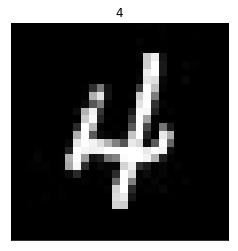

In [13]:
predictions = next(iterator)

img = predictions["image"]
class_id = np.argmax(predictions["classes"])

ax = plt.axes()

plt.imshow(img[:, :, 0], cmap="gray")

ax.title.set_text(class_id)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

## Freeze Graph

In [ ]:
params = dicto.load_("parameters.yml")

graph = tf.Graph()
with graph.as_default():
    inputs = dict(
        image = tf.layers.Input(shape=(28, 28, 1)),
        mode = tf.estimator.ModeKeys.TRAIN,
    )

    all_cnn = AllCNNN()
    logits, predictions = all_cnn(inputs)
    
    saver = tf.train.Saver()

In [ ]:
params = dicto.load_("parameters.yml")

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)
snapshot_fpath = tf.train.latest_checkpoint(params.model_dir)
saver.restore(sess, snapshot_fpath)

In [20]:
from tensorflow.python.framework import graph_io

params = dicto.load_("parameters.yml")

graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())

graphdef_frozen = tf.graph_util.convert_variables_to_constants(
    sess, graphdef_inf, params.OUTPUT_NAMES)

graph_io.write_graph(graphdef_frozen, './', params.FROZEN_FPATH, as_text=False)

INFO:tensorflow:Froze 14 variables.
Converted 14 variables to const ops.


'./frozen_models/all_cnn1.pb'

In [21]:
[x.name for x in graphdef_frozen.node]

[u'input_layer_1',
 u'AllCNN/Conv2dBatchNorm/conv2d/kernel',
 u'AllCNN/Conv2dBatchNorm/conv2d/bias',
 u'AllCNN/Conv2dBatchNorm/conv2d/Conv2D',
 u'AllCNN/Conv2dBatchNorm/conv2d/BiasAdd',
 u'AllCNN/Conv2dBatchNorm/batch_normalization/gamma',
 u'AllCNN/Conv2dBatchNorm/batch_normalization/beta',
 u'AllCNN/Conv2dBatchNorm/batch_normalization/Const',
 u'AllCNN/Conv2dBatchNorm/batch_normalization/Const_1',
 u'AllCNN/Conv2dBatchNorm/batch_normalization/FusedBatchNorm',
 u'AllCNN/Conv2dBatchNorm/Elu',
 u'AllCNN/Conv2dBatchNorm_1/conv2d/kernel',
 u'AllCNN/Conv2dBatchNorm_1/conv2d/bias',
 u'AllCNN/Conv2dBatchNorm_1/conv2d/Conv2D',
 u'AllCNN/Conv2dBatchNorm_1/conv2d/BiasAdd',
 u'AllCNN/Conv2dBatchNorm_1/batch_normalization/gamma',
 u'AllCNN/Conv2dBatchNorm_1/batch_normalization/beta',
 u'AllCNN/Conv2dBatchNorm_1/batch_normalization/Const',
 u'AllCNN/Conv2dBatchNorm_1/batch_normalization/Const_1',
 u'AllCNN/Conv2dBatchNorm_1/batch_normalization/FusedBatchNorm',
 u'AllCNN/Conv2dBatchNorm_1/Elu',
 u'

## UFF

In [6]:
import tensorrt as trt
import uff
from tensorrt.parsers import uffparser

MAX_WORKSPACE = 1 << 20 # ADJUST

In [23]:
params = dicto.load_("parameters.yml")

uff_model = uff.from_tensorflow_frozen_model(
    params.FROZEN_FPATH, 
    params.OUTPUT_NAMES
)

Using output node AllCNN/Softmax
Converting to UFF graph
Converting as custom op Elu AllCNN/conv2d/Elu
name: "AllCNN/conv2d/Elu"
op: "Elu"
input: "AllCNN/conv2d/BiasAdd"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

Converting as custom op Elu AllCNN/Conv2dBatchNorm_2/Elu
name: "AllCNN/Conv2dBatchNorm_2/Elu"
op: "Elu"
input: "AllCNN/Conv2dBatchNorm_2/batch_normalization/FusedBatchNorm"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

Converting as custom op Elu AllCNN/Conv2dBatchNorm_1/Elu
name: "AllCNN/Conv2dBatchNorm_1/Elu"
op: "Elu"
input: "AllCNN/Conv2dBatchNorm_1/batch_normalization/FusedBatchNorm"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

Converting as custom op Elu AllCNN/Conv2dBatchNorm/Elu
name: "AllCNN/Conv2dBatchNorm/Elu"
op: "Elu"
input: "AllCNN/Conv2dBatchNorm/batch_normalization/FusedBatchNorm"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

No. nodes: 39


In [31]:
params = dicto.load_("parameters.yml")

parser = uffparser.create_uff_parser()

for input_ in params.INPUTS:
    parser.register_input(input_.name, input_.size, 0)

for output in params.OUTPUT_NAMES:
    parser.register_output(output)

G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.INTERNAL_ERROR)

In [7]:
params = dicto.load_("parameters.yml")

graph = tf.Graph()
sess = tf.Session(graph = graph)

with graph.as_default():
    
    inputs = dict(
        image = tf.layers.Input(shape=(28, 28, 1)),
        mode = tf.estimator.ModeKeys.TRAIN,
    )

    all_cnn = AllCNNN()
    logits, predictions = all_cnn(inputs)
    
    graph_def = graph.as_graph_def()
    
    print(predictions.graph)
    print(graph)
    print(sess.graph)
    
    saver = tf.train.Saver()
    
    snapshot_fpath = tf.train.latest_checkpoint(params.model_dir)
    saver.restore(sess, snapshot_fpath)
    
    # freeze graph and remove nodes used for training 
    frozen_graph = tf.graph_util.convert_variables_to_constants(sess, graph_def, params.OUTPUT_NAMES)
    frozen_graph = tf.graph_util.remove_training_nodes(frozen_graph)
    # Create UFF model and dump it on disk 
    uff_model = uff.from_tensorflow(frozen_graph, [predictions.name])
    dump = open('all_cnn.uff', 'wb')
    dump.write(uff_model)
    dump.close()

InternalError: Failed to create session.

In [17]:
predictions.name

u'AllCNN/Softmax:0'